# NeuroM Tutorial Notebook

NeuroM contains helper functions that allow to easily load neuronal morphologies from files into NeuroM data structures. It also provides convenient methods to query various properties of the morphologies, as well as an easy way to visualize morphological objects.

In [1]:
%%capture
!pip install NeuroM[plotly]

In [2]:
%matplotlib inline

# Import neurom module
import neurom as nm
# Import neurom visualization module
from neurom import viewer
from neurom.view import plotly

## 1. Loading a morphology or a population

NeuroM can load morphologies from swc, h5 or NL ascii files. Please note that the Neurolucida ascii reader is experimental! There are no guarantees regarding correctness of loading data from files in this format.

In [3]:
# Load a single morphology  
neuron = nm.load_neuron('../test_data/valid_set/Neuron.swc')

# Load a population of morphologies from a set of files
pop = nm.load_neurons('../test_data/valid_set/')

# Get a single morphology from the population
single_neuron = pop.neurons[0]

## 2. Morphology visualization

In [4]:
# Visualize a morphology in two dimensions
fig, ax = plotly.draw(neuron, plane='xy', inline=True)

In [5]:
# Visualize a morphology in three dimensions
fig, ax = plotly.draw(neuron, inline=True)

In [6]:
# Visualize a single tree in three dimensions
fig, ax = plotly.draw(neuron.neurites[0], inline=True)

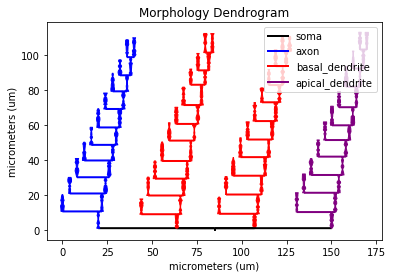

In [7]:
# Visualize the dendrogram of a morphology
fig, ax = viewer.draw(neuron, mode='dendrogram')

## 3. Morphology analysis

### 3.1 Morphometrics extraction

In [8]:
# Extract the total number of neurites (basal and apical dendrites, and axons)
number_of_neurites = nm.get('number_of_neurites', neuron)

# Extract the total number of sections
number_of_sections = nm.get('number_of_sections', neuron)

# Extract the soma radius
soma_radius = neuron.soma.radius

# Extract the number of sections per neurite
number_of_sections_per_neurite = nm.get('number_of_sections_per_neurite', neuron)

# Print result
print("Neuron id          : {0} \n\
Number of neurites : {1} \n\
Soma radius        : {2:.2f} \n\
Number of sections : {3}".format(neuron.name, number_of_neurites[0], soma_radius, number_of_sections[0]))
print()
print("Neurite type \t\t\t| Number of sections")
for i, neurite in enumerate(neuron.neurites):    
    print("{0:31} | {1}".format(str(neurite.type), number_of_sections_per_neurite[i]))

Neuron id          : Neuron 
Number of neurites : 4 
Soma radius        : 0.13 
Number of sections : 84

Neurite type 			| Number of sections
NeuriteType.axon                | 21
NeuriteType.basal_dendrite      | 21
NeuriteType.basal_dendrite      | 21
NeuriteType.apical_dendrite     | 21


In [9]:
# Extract the lengths of the sections
section_lengths = nm.get('section_lengths', neuron)

# Extract the lengths of the segments
segment_lengths = nm.get('segment_lengths', neuron)

# Extract the local bifurcation angles
local_bif_angles = nm.get('local_bifurcation_angles', neuron)

# Extract the remote bifurcation angles
remote_bif_angles = nm.get('remote_bifurcation_angles', neuron)

# Extract the radial distances of the sections
section_radial_distances = nm.get('section_radial_distances', neuron)

# Extract the path distances of the sections
section_path_distances = nm.get('section_path_distances', neuron)

# Print result
features = (segment_lengths, section_lengths, local_bif_angles, 
            remote_bif_angles, section_path_distances, section_radial_distances)

def check(feature_list, n): 
    return '{0:.2f}'.format(feature_list[n]) if n < len(feature_list) else ''

print('|sg_len|sc_len|lc_bif_angles|rm_bif_angles|sc_path_dists|sc_rad_dists|')
for n in range(0, 50):
    args = (check(f, n) for f in features)
    print('|{0:^6}|{1:^6}|{2:^13}|{3:^13}|{4:^13}|{5:^12}|'.format(*args))

|sg_len|sc_len|lc_bif_angles|rm_bif_angles|sc_path_dists|sc_rad_dists|
| 0.10 | 9.58 |    2.09     |    0.34     |    9.58     |    8.84    |
| 0.65 | 9.65 |    2.09     |    0.57     |    19.23    |   15.75    |
| 1.01 |10.26 |    2.09     |    0.59     |    19.84    |   16.74    |
| 1.06 | 9.19 |    2.09     |    0.49     |    29.03    |   23.23    |
| 1.15 | 9.28 |    2.09     |    0.16     |    29.12    |   23.07    |
| 0.94 |10.73 |    2.09     |    0.52     |    39.85    |   30.58    |
| 1.30 | 9.59 |    2.09     |    0.76     |    38.71    |   30.18    |
| 1.09 |10.45 |    2.09     |    0.47     |    49.17    |   37.80    |
| 1.18 | 8.93 |    2.09     |    0.72     |    47.64    |   36.63    |
| 1.09 |10.05 |    2.09     |    0.34     |    57.70    |   44.10    |
| 1.41 | 9.97 |    2.09     |    0.58     |    57.61    |   43.97    |
| 0.93 |10.72 |    2.09     |    0.26     |    68.33    |   51.29    |
| 0.80 |10.55 |    2.09     |    0.12     |    68.16    |   51.92    |
| 1.12

### 3.2 Analyze different types of trees

The previous examples treated all neurites in the same way. NeuroM allows you to extract morphometrics for a selected type of trees.

In [10]:
# Extract the section lengths of axonal trees
ax_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.AXON)

# Extract the section lengths of basal dendrite trees
ba_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.BASAL_DENDRITE)

# Extract the section lengths of apical dendrite trees
ap_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.APICAL_DENDRITE)

print('\nAxonal section lengths = ', ax_section_lengths)
print('\nBasal section lengths =  ', ba_section_lengths)
print('\nApical section lengths = ', ap_section_lengths)


Axonal section lengths =  [ 9.57911737  9.64901212 10.26444194  9.18963499  9.28095558 10.72637819
  9.58862945 10.45414656  8.92750196 10.05466932  9.96815205 10.72221858
 10.55440382  9.11262954 10.09303133 10.33071556  9.17709438  8.86068767
 10.37491982  9.95295124 11.01846074]

Basal section lengths =   [ 7.97232242  8.73002814 10.71154672 10.51683552  9.63361814 10.1348335
 10.1034446  10.90464832 11.65250813 10.20352358  9.54012263  9.53084499
 10.79778536 10.25222844 11.60598013  8.92943746  8.23366666  9.66996901
 10.13395757 10.96762258 10.89245052  8.22452877  9.59239376 11.0190682
 10.25855549 10.75631381 10.38491293 10.62047288 11.05192629 10.06943611
 10.10998146 10.55534081 10.58562592 10.74722939  8.23176374  9.8508199
  8.93049233 10.73839347  9.48292967  8.58137852  9.0358861   8.48759244]

Apical section lengths =  [ 9.21270799 11.05092479 11.02994892 10.7541096  10.17670693  9.36444805
 10.49054247  9.52925566  9.49194374 10.36496319  8.42121218 10.92441795
 10.347

### 3.3 Perform statistical analysis on extracted measurements

Now we are ready to extract basic statistical measurements, using common Python functions. For this, we will use [`numpy`](http://www.numpy.org/), which is a package for scientific computing with Python.

In [11]:
import numpy as np

# We can get the mean section length
mean_sl = np.mean(section_lengths)

# We can get the standard deviation of the section lengths
std_sl = np.std(section_lengths)

# We can get the minimum section length
min_sl = np.min(section_lengths)

# ... and the maximum section length
max_sl = np.max(section_lengths)

print('Section length statistics:')
print('  [mean, std] = [{0:.2f}, {1:.2f}]'.format(mean_sl, std_sl))
print('  [min, max]: [{0:.2f}, {1:.2f}]'.format(min_sl, max_sl))

Section length statistics:
  [mean, std] = [10.01, 0.86]
  [min, max]: [7.97, 11.76]


### 3.4 Generate plots from the extracted morphometrics

The distribution of the extracted measurements can be plotted with [`matplotlib`](http://matplotlib.org/), which is a Python library for plot generation. We will use the [`matplotlib.pyplot`](http://matplotlib.org/api/pyplot_api.html) sub module.

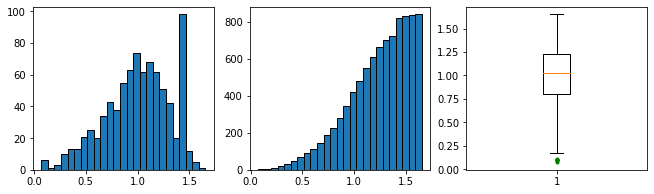

In [12]:
import matplotlib.pyplot as plt

# Select the feature of choice
feature = nm.get('segment_lengths', neuron)

# Create empty figure
fig = plt.figure(figsize=(11,3))

# Create histogram
ax = fig.add_subplot('131')
ax.hist(feature, bins=25, edgecolor='black')

# Create cumulative histogram
ax = fig.add_subplot('132')
ax.hist(feature, bins=25, cumulative=True, edgecolor='black')

# Create boxplot; flier points are indicated with green dots
ax = fig.add_subplot('133')
_ = ax.boxplot(feature, sym='g.')

### 3.5 Fit the extracted data with a statistical distribution

Now we are ready to fit the extracted data using common Python functions. For this, we will use [`scipy`](http://www.scipy.org/), which is a package for numerical routines for scientific computing with Python.

In [13]:
from neurom import stats

data = nm.get('segment_lengths', neuron)

# Let’s start with a normal distribution. We will fit the data that we extracted above with a normal distribution
p = stats.fit(data, distribution='norm')

# The output of the function is a named tuple of type FitResults
print('Fit output type : ', type(p))

# The parameters are stored in the variable params, which in the case of the normal distribution stores the mu and sigma
# of the normal distribution
mu, sigma = p.params
ks_dist, pvalue = p.errs

# Print result
print('[mu, sigma] : [{0:.2f}, {1:.2f}]\n'.format(mu, sigma))

# We need to check the statistical error of the performed fit to evaluate the accuracy of the 
# selected model. To do so we use the errors variable of FitResults:
print('Kolmogorov-Smirnov distance : {0:.2f}'.format(ks_dist))
print('P-value : {0:.2f}'.format(pvalue))

Fit output type :  <class 'neurom.stats.FitResults'>
[mu, sigma] : [1.00, 0.31]

Kolmogorov-Smirnov distance : 0.05
P-value : 0.02


The result of the fitting can be visualized:

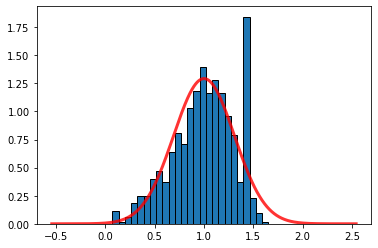

In [14]:
from scipy.stats import norm

# Create a histogram as above
fig = plt.figure()
plt.hist(data, bins=25, density=True, edgecolor='black')

# Plot range: 5 standard deviations around the mean
norm_range = np.arange(mu - 5.*sigma, mu + 5.*sigma, 0.001)

# Plot the normal pdf with the given range, mu and sigma
_ = plt.plot(norm_range, norm.pdf(norm_range, mu, sigma), linewidth=3., c='r', alpha=0.8)

It is also possible to find the optimal distribution that best fits the data, among a number of distributions that are
supported by `scipy`:

In [15]:
p = stats.optimal_distribution(data, distr_to_check=('lognorm', 'logistic', 'norm'))
print('Fit results:', p)

Fit results: FitResults(params=(1.0008157314553803, 0.30873679377786745), errs=KstestResult(statistic=0.05338096254357494, pvalue=0.016059728228707635), type='norm')


### 3.6 Apply more advanced manipulation on extracted data

In this example, we extract all section lengths that exceed a selected threshold.

In [16]:
# Threshold value
threshold = 10

# Get the ids of sections which length exceeds the threshold
selected_ids = np.where(section_lengths > threshold)

# Get the values of section lengths that exceed the threshold
section_lengths[selected_ids]

array([10.26444194, 10.72637819, 10.45414656, 10.05466932, 10.72221858,
       10.55440382, 10.09303133, 10.33071556, 10.37491982, 11.01846074,
       10.71154672, 10.51683552, 10.1348335 , 10.1034446 , 10.90464832,
       11.65250813, 10.20352358, 10.79778536, 10.25222844, 11.60598013,
       10.13395757, 10.96762258, 10.89245052, 11.0190682 , 10.25855549,
       10.75631381, 10.38491293, 10.62047288, 11.05192629, 10.06943611,
       10.10998146, 10.55534081, 10.58562592, 10.74722939, 10.73839347,
       11.05092479, 11.02994892, 10.7541096 , 10.17670693, 10.49054247,
       10.36496319, 10.92441795, 10.34721651, 11.75828156, 11.56005879,
       10.38431278, 10.85399109])

### 3.7 Combine morphometrics

We can study relations between different morphometrics. For example, we can combine section length and path length to soma:

In [17]:
# Get the length of all sections with a radial distance between 0.0 and 60.0
section_indices = np.where((section_radial_distances >= 0.0) & (section_radial_distances < 60.0))
selected_section_lengths = section_lengths[section_indices]
print(selected_section_lengths)

[ 9.57911737  9.64901212 10.26444194  9.18963499  9.28095558 10.72637819
  9.58862945 10.45414656  8.92750196 10.05466932  9.96815205 10.72221858
 10.55440382  9.11262954 10.09303133  7.97232242  8.73002814 10.71154672
 10.51683552  9.63361814 10.1348335  10.1034446  10.90464832 11.65250813
 10.20352358  9.54012263  9.53084499 10.79778536  8.22452877  9.59239376
 11.0190682  10.25855549 10.75631381 10.38491293 10.62047288 11.05192629
 10.06943611 10.10998146 10.55534081 10.58562592 10.74722939  8.23176374
  9.8508199   9.21270799 11.05092479 11.02994892 10.7541096  10.17670693
  9.36444805 10.49054247  9.52925566  9.49194374 10.36496319  8.42121218
 10.92441795]
